# H.A. Rey constellations mnemonic cars
This project aims to create mnemonic cards of various constellations, using similar aesthetics as the drawings of H. A. Rey in his book  _Find the constellations_. The notebook uses the data from Hipparcos and the constellations informations from the section _sky cultures_ of Stellarium.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
import pandas as pd


In [31]:
import json, wget

def load_hipparcos():
    '''Read the hipparcos dataframe. If it is the first time, downloads it from the URL'''
    filename = 'hipparcos_stars.dat'
    url = 'https://cdsarc.u-strasbg.fr/ftp/cats/I/239/hip_main.dat'
    try:
        df = pd.read_csv(filename)
        df.set_index('hip', inplace=True)
    except FileNotFoundError:
        print("Loading Hipparcos star catalogue")
        df = pd.read_csv(url, sep='|',  usecols=[1,5,8,9], na_values=['     ', '       ', '        ', '            '])
        df.columns = ('hip', 'magnitude', 'ra_degrees', 'dec_degrees')
        df.set_index('hip', inplace=True)
        
        df.to_csv(filename, index=True, header=True)
    return df

def get_constellations(url='https://raw.githubusercontent.com/Stellarium/stellarium-skycultures/refs/heads/master/western_rey/index.json'):
    '''Read the json file containing the stars that are part of a constellation shape
        If it is the first time, downloads the file and saves it from url'''
    
    filename = 'constellation.json'
    try:
        f = open(filename, 'r')    
    except FileNotFoundError: 
        wget.download(url, filename)
        f = open(filename, 'r')
    
    data = json.load(f)
    f.close()
    
    # Polishing the data a little
    data = data['constellations']
    #Rearranging the data in a dictionary having for key the id and for values the edges and the names
    constellations = dict([(c['id'].split()[2], {'name': c['common_name']['english'], 'lines':c['lines']}) for c in data])
    
    return constellations

In [32]:
constellations = get_constellations()
stars = load_hipparcos()
    

## Plot the whole sky map

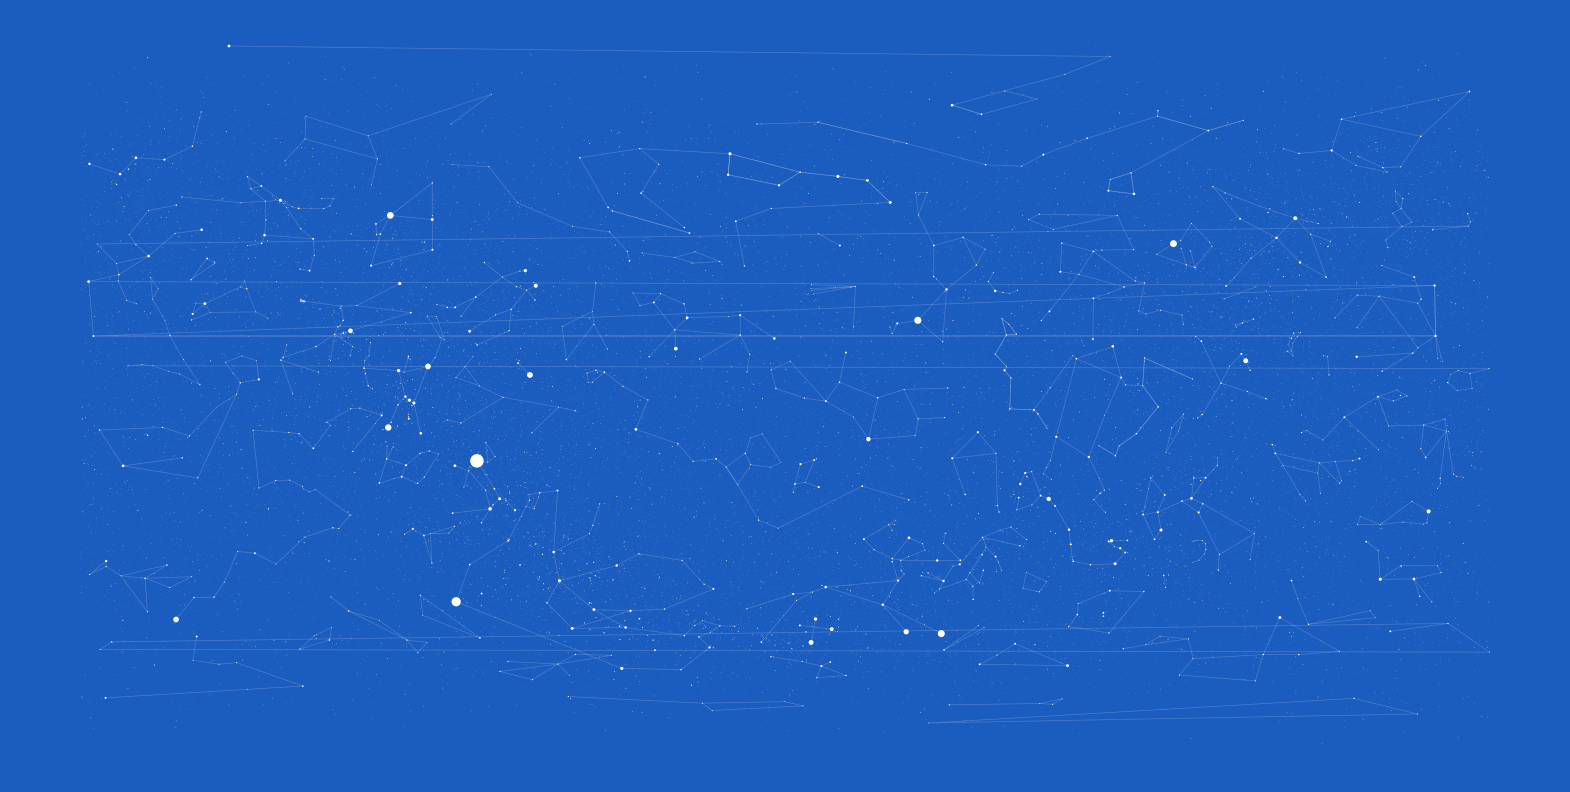

In [33]:
bkg_color = '#1b5dbf'

# Define the number of stars and brightness of stars to include
limiting_magnitude = 10
bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = 100*10 ** (magnitude / -2.5)

#Creating the constellations lines
constellation_lines = [line for c in constellations for line in constellations[c]['lines']]

fig, ax = plt.subplots(figsize=(20,20), facecolor=bkg_color)

for line in constellation_lines:
    ax.plot(stars['ra_degrees'][line], stars['dec_degrees'][line], color='w', linewidth=0.5, alpha=0.2)

# Draw the stars.
ax.scatter(stars['ra_degrees'][bright_stars], stars['dec_degrees'][bright_stars],
            s=marker_size, color='white', marker='.', linewidths=0,
            zorder=2)

# Finally, add other settings
ax.set_aspect('equal')
ax.set_axis_off()

plt.show()
plt.close()
    

### Importing custom markers

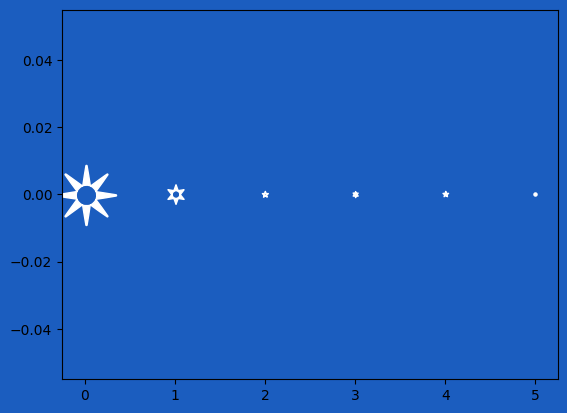

In [34]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

star_markers = []

for i in range(5):
    _, attributes = svg2paths(f'markers/star_marker_{i}.svg')
    star_marker = parse_path(attributes[0]['d'])
    star_marker.vertices -= star_marker.vertices.mean(axis=0)
    star_markers.append(star_marker)

star_markers = star_markers + ['.']

fig,ax = plt.subplots(facecolor=bkg_color)
ax.set_facecolor(bkg_color)
sizes = np.array([100,10,1,1,1,1])

for point, m, size in zip(range(6), star_markers, sizes):
    ax.scatter(point, 0, marker=m, color='w', s = 20*size)

In [35]:
reduced_mag = lambda x : 0 if x< 0.5 else 6 if x >= 5.5 or np.isnan(x) else np.floor(x)

stars['mag_class'] = np.vectorize(reduced_mag)(stars['magnitude'])

## Stereographic projection 

In [36]:
def build_stereographic_projection(ra_degrees, dec_degrees):
    """Compute *x* and *y* coordinates at which to plot the positions."""
    ra, dec = np.deg2rad(ra_degrees), np.deg2rad(dec_degrees)
    x_c = np.cos(ra)*np.cos(dec)
    y_c = np.sin(ra)*np.cos(dec)
    z_c = np.sin(dec)

    def project(ra_degrees, dec_degrees):
        
        ra, dec = np.deg2rad(ra_degrees), np.deg2rad(dec_degrees)
        x = np.cos(ra)*np.cos(dec)
        y = np.sin(ra)*np.cos(dec)
        z = np.sin(dec)

        t0 = 1/np.sqrt(x_c**2 + y_c**2)
        t1 = x*x_c
        t2 = np.sqrt(-z_c**2 + 1)
        t3 = t0*t2
        t4 = y*y_c
        t5 = 1/(t1*t3 + t3*t4 + z*z_c + 1)
        t6 = t0*z_c

        return t0*t5*(x*y_c - x_c*y), -t5*(t1*t6 - t2*z + t4*t6)

    return project


In [37]:
def project_constellation(id, limiting_magnitude=5.5):
    '''Returns a dataframe containing the stars around the constellation projected and centered 
    around the constellation.'''
    
    lines = constellations[id]['lines']

    # The shape stars are the ones that are used to create the constellation
    shape_stars_maks = sum(lines, [])
    shape_stars = stars.iloc[shape_stars_maks]

    # Taking the brightest star to project everything around it 
    brightest_star = shape_stars.iloc[np.argmin(shape_stars['magnitude'])]

    # Project around the brightest star
    projection = build_stereographic_projection(brightest_star['ra_degrees'], brightest_star['dec_degrees'])
    stars['x'],stars['y']  = projection(stars['ra_degrees'], stars['dec_degrees'])

    # Find the extremes of the constellations
    padding = 0.1
    min_x = np.min(stars['x'][shape_stars_maks]) 
    min_y = np.min(stars['y'][shape_stars_maks]) 
    max_x = np.max(stars['x'][shape_stars_maks]) 
    max_y = np.max(stars['y'][shape_stars_maks]) 

    pad_x = padding*(max_x - min_x)
    pad_y = padding*(max_y - min_y)


    return stars, (min_x-pad_x, max_x+pad_x), (min_y-pad_y, max_y+pad_y), shape_stars_maks

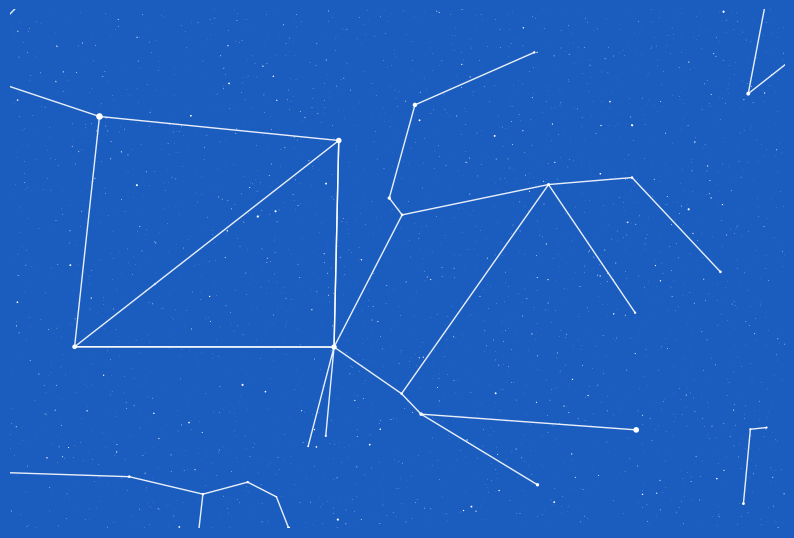

In [38]:
stars, borders_x, borders_y, _  = project_constellation('Peg')
marker_size = 150*10**(stars['magnitude']/-2.5)

fig, ax = plt.subplots(figsize=(10,10), facecolor=bkg_color)

for line in constellation_lines:
    ax.plot(stars['x'][line], stars['y'][line], color='w', linewidth=1.0, alpha=0.9)

# Draw the stars.
ax.scatter(stars['x'], stars['y'],s=marker_size, color='white', marker='o', linewidths=0, zorder=2)

# Finally, add other settings
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_xlim(borders_x)
ax.set_ylim(borders_y)

#plt.savefig(filename, format='png', dpi=1200)

plt.show()
plt.close()


In [39]:
constellations.keys()

dict_keys(['BgD', 'UMaP', 'UMi', 'UMiG', 'Dra', 'DraF', 'DraH', 'DraT', 'Cas', 'Cep', 'Cam', 'Uma', 'UMah', 'UMap1', 'UMap2', 'Leo', 'Leoh', 'Leot', 'CVn', 'LMi', 'Boo', 'Boob', 'Booh', 'Boop', 'Com', 'CrB', 'Cyg', 'Cygw1', 'Cygw2', 'Cygf', 'Cygn', 'Lyr', 'Vul', 'Her', 'Herc', 'Herk', 'Lac', 'Tri', 'And', 'Andc', 'GSq', 'Peg', 'Pegh', 'Pegt', 'Pegw', 'Per', 'Ari', 'Arih', 'Arit', 'Tau', 'Tauh', 'Tauc1', 'Tauc2', 'Taut', 'Aur', 'Lyn', 'Gem', 'CMi', 'Cnc', 'Mon', 'Ori', 'Orib', 'Oric', 'Oris', 'Lep', 'CMa', 'Eri', 'Hya', 'Hyah', 'Crt', 'Ant', 'Hyat', 'Vir', 'Virh', 'Virf', 'Lib', 'Crv', 'Crvb', 'Crvf', 'Crvt', 'Ser', 'SerCd', 'SerCp', 'SerHh', 'Oph', 'Ophb', 'Ophh', 'Opha1', 'Opha2', 'Ophf1', 'Ophf2', 'Sco', 'Scoc', 'Scot', 'Scoe', 'Sge', 'Del', 'Aql', 'Aqlh', 'Aqlw1', 'Aqlw2', 'Aqlt', 'Sct', 'Sgr', 'Sgrh', 'Sgrb', 'Sgrs', 'Sgrt', 'CrA', 'Equ', 'Aqr', 'Aqrh', 'Aqra', 'Aqrv', 'Cap', 'PsA', 'Gru', 'Phe', 'Psc', 'PscN', 'PscW', 'Cet', 'Cett', 'Scl', 'Vel', 'Pyx', 'CruF', 'Car', 'Carh', 'Pup

# Plotting with simple balls or with custom markers


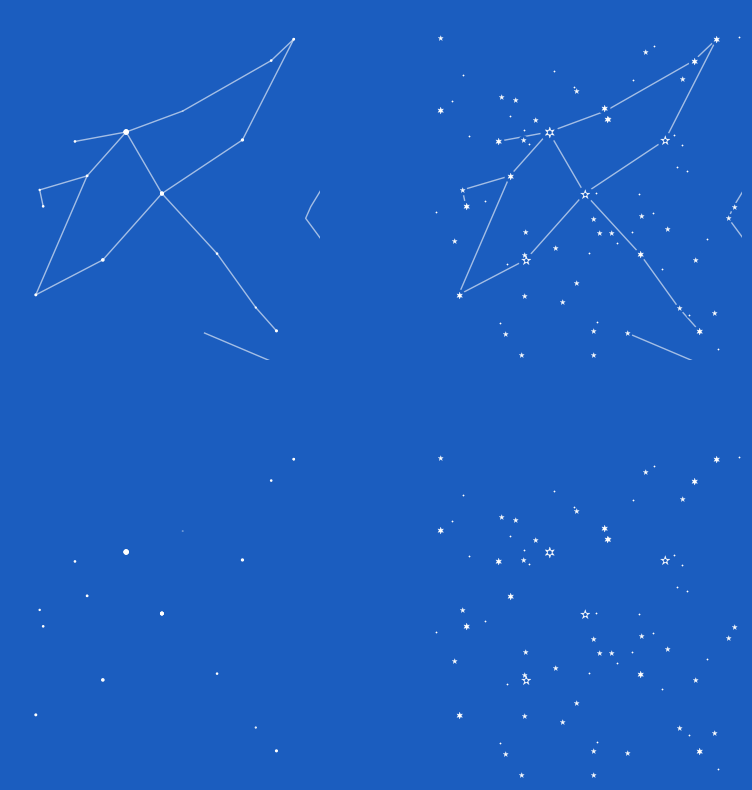

In [40]:
stars, borders_x, borders_y, shape_stars_mask = project_constellation('Cyg')



bright_stars = stars['magnitude']<5.5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10), facecolor=bkg_color)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_xlim(borders_x)
    ax.set_ylim(borders_y)

sizes = [11,8,7,5,4,2]

for line in constellation_lines:
    ax1.plot(stars['x'][line], stars['y'][line], color='white', linewidth=1, alpha=0.6)
    ax2.plot(stars['x'][line], stars['y'][line], color='white', linewidth=1, alpha=0.6)

marker_size = 100*10 ** (stars['magnitude'][shape_stars_mask] / -2.5)
for ax in (ax1,ax3):
    ax.scatter(stars['x'][shape_stars_mask], stars['y'][shape_stars_mask], color='w', marker='.', s=marker_size)

for ax in (ax2,ax4):
    for i, (m, s) in enumerate(zip(star_markers,sizes)):
        mask = stars['mag_class']==i
        ax.plot(stars['x'][mask], stars['y'][mask], linestyle = '', marker='o', markerfacecolor=bkg_color, markeredgecolor=bkg_color, markersize=1.5*s)
    for i, (m, s) in enumerate(zip(star_markers,sizes)):
        mask = stars['mag_class']==i
        ax.plot(stars['x'][mask], stars['y'][mask], linestyle = '', marker=m, markerfacecolor='w', markeredgecolor='w', markeredgewidth=0.2,  markersize=s)
plt.show()

## Creating a card structure

In [41]:
ar = 11/19 # width/height ratio of a tarot
ar_fig = 11/16 #

In [42]:
import matplotlib.patches as mpatches
import matplotlib.axes as axes
from matplotlib.projections import register_projection
from pyfonts import load_font

class StaticColorAxisBBox(mpatches.FancyBboxPatch):
    def set_edgecolor(self, color):
        if hasattr(self, "_original_edgecolor"):
            return
        self._original_edgecolor = color
        self._set_edgecolor(color)

    def set_linewidth(self, w):
        super().set_linewidth(1.5)

class FancyAxes(axes.Axes):
    name = "fancy_box_axes"
    _edgecolor: str

    def __init__(self, *args, **kwargs):
        self._edgecolor = kwargs.pop("edgecolor", None)
        self.aspect_ratio = kwargs.pop("ar", 1.0)
        super().__init__(*args, **kwargs)

    def _gen_axes_patch(self):
        return StaticColorAxisBBox(
            (0, 0),
            1.0,
            1.0,
            boxstyle="round, rounding_size=0.06, pad=0",
            mutation_aspect=self.aspect_ratio,
            edgecolor=self._edgecolor,
            linewidth=5
        )

register_projection(FancyAxes)
font = load_font('https://github.com/NDISCOVER/Cinzel/blob/master/fonts/ttf/CinzelDecorative-Black.ttf?raw=true')

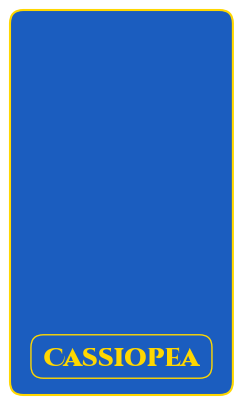

In [43]:
figure = plt.figure(figsize=[ar*5, 5], facecolor=None)
ax = figure.add_subplot(
    111, projection="fancy_box_axes",
    facecolor=bkg_color,
    edgecolor='gold',
    ar=ar
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0,1])
ax.set_ylim([0,1/ar])
ax.spines[["bottom", "left", "right", "top"]].set_visible(False)

text_box = dict(facecolor=bkg_color, edgecolor='gold', boxstyle='round,pad=0.5', linewidth=1)
ax.text(0.5, 0.1, 'Cassiopea', font=font, color = 'gold', 
        horizontalalignment='center', verticalalignment='center',
        transform = ax.transAxes, bbox=text_box, fontsize=18)
ax.set_aspect('equal')
plt.show()

## Function to create a card

In [47]:
def create_cards(id):

    name = constellations[id]['name']
    stars, borders_x, borders_y, _ = project_constellation(id)

    # Renormalizing the borders so they are inside the (0,1), (0,1/ar) plot
  
    stars['x'] = (stars['x'] - borders_x[0])/(borders_x[1]-borders_x[0])
    stars['y'] = (stars['y'] - borders_y[0])/(borders_x[1]-borders_x[0]) + (1/ar -1)

   ############## Plotting the two cards #########################################
    figure_bare = plt.figure(figsize=[5*ar, 5], facecolor=None)
    ax = figure_bare.add_subplot(
        111, projection="fancy_box_axes",
        facecolor=bkg_color,
        edgecolor='gold',
        ar=ar
    )
    for i, (m, s) in enumerate(zip(star_markers,sizes)):
        mask = stars.mag_class==i
        ax.plot(stars['x'][mask], stars['y'][mask], linestyle = '', marker='o', markerfacecolor=bkg_color, markeredgecolor=bkg_color, markersize=1.5*s)
        ax.plot(stars['x'][mask], stars['y'][mask], linestyle = '', marker=m, markerfacecolor='w', markeredgecolor='w', markeredgewidth=0.2,  markersize=s)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0,1])
    ax.set_ylim([0,1/ar])
    ax.spines[["bottom", "left", "right", "top"]].set_visible(False)

    ax.set_aspect('equal')

    plt.savefig(f'{name}_bare.png')
    plt.show()

    figure_lines = plt.figure(figsize=[5*ar, 5], facecolor=None)
    ax = figure_lines.add_subplot(
        111, projection="fancy_box_axes",
        facecolor=bkg_color,
        edgecolor='gold',
        ar=ar
    )
    for line in constellation_lines:
        ax.plot(stars['x'][line], stars['y'][line], color='white', linewidth=1, alpha=0.6)
    for i, (m, s) in enumerate(zip(star_markers,sizes)):
        mask = stars.mag_class==i
        ax.plot(stars['x'][mask], stars['y'][mask], linestyle = '', marker='o', markerfacecolor=bkg_color, markeredgecolor=bkg_color, markersize=1.5*s)
        ax.plot(stars['x'][mask], stars['y'][mask], linestyle = '', marker=m, markerfacecolor='w', markeredgecolor='w', markeredgewidth=0.2,  markersize=s)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0,1])
    ax.set_ylim([0,1/ar])
    ax.spines[["bottom", "left", "right", "top"]].set_visible(False)

    text_box = dict(facecolor=bkg_color, edgecolor='gold', boxstyle='round,pad=0.5', linewidth=1)
    ax.text(0.5, 0.1, name, font=font, color = 'gold', 
            horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, bbox=text_box, fontsize=18)
    ax.set_aspect('equal')
    plt.savefig(f'{name}_lines.png')

    plt.show()

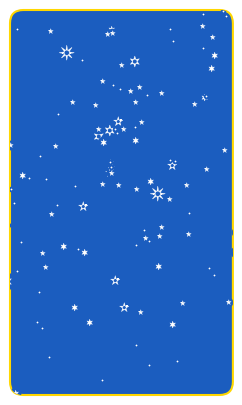

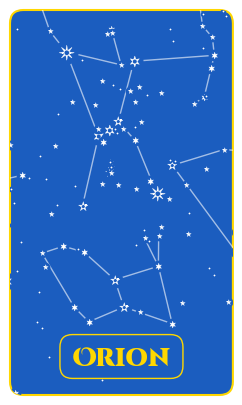

In [48]:
create_cards('Ori')

In [49]:
a = np.zeros(10)
a[[1,3,5]] = 1
a

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])